In [12]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import os
from glob import glob
parent_path = os.path.abspath("./../")
if os.path.basename(parent_path) == 'vdp':
    os.chdir(parent_path)

In [25]:
def query_jsons(globbed_list):
    custom_predictions = dict()
    custom_data_infos = dict()
    
    for path in globbed_list:
        for batch in ['test', 'train']:
            with open(path + f"/{batch}/custom_prediction.json", 'r') as fp:
                custom_predictions[(os.path.basename(path), batch)] = json.load(fp)
            with open(path + f"/{batch}/custom_data_info.json", 'r') as fp:
                custom_data_infos[(os.path.basename(path), batch)] = json.load(fp)

    return custom_predictions, custom_data_infos

custom_predictions, custom_data_infos = query_jsons(glob("./data/sg_processed/*"))

In [26]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)


def clean_image_paths(img_list, raw_directory="./data/raw/"):
    return [raw_directory + os.path.basename(img_path) for img_path in img_list]
        

In [27]:
list(custom_predictions.keys())

[('alldogsonsofas_abc-23d', 'test'),
 ('alldogsonsofas_abc-23d', 'train'),
 ('kitchen_abc-1.12.1e', 'test'),
 ('kitchen_abc-1.12.1e', 'train'),
 ('catontv_ab-1.22.1c', 'test'),
 ('catontv_ab-1.22.1c', 'train'),
 ('topmost_abc-13e', 'test'),
 ('topmost_abc-13e', 'train'),
 ('2on1_abe-c123', 'test'),
 ('2on1_abe-c123', 'train'),
 ('sleeping_abc-1.22.2d', 'test'),
 ('sleeping_abc-1.22.2d', 'train'),
 ('desktop_abc-1.12.13.1e', 'test'),
 ('desktop_abc-1.12.13.1e', 'train'),
 ('populatedbus_abc-1.12.2d', 'test'),
 ('populatedbus_abc-1.12.2d', 'train'),
 ('dogherded_abc-1.12.23.1d', 'test'),
 ('dogherded_abc-1.12.23.1d', 'train'),
 ('umbrella_abc-135d', 'test'),
 ('umbrella_abc-135d', 'train'),
 ('pplandties_abc-1.22.1e', 'test'),
 ('pplandties_abc-1.22.1e', 'train'),
 ('parkmeter_abc-234d', 'test'),
 ('parkmeter_abc-234d', 'train'),
 ('tvon_abc-13d', 'test'),
 ('tvon_abc-13d', 'train'),
 ('diagonal_ab-14c', 'test'),
 ('diagonal_ab-14c', 'train'),
 ('pplwearingties_abc-1.12.13.1e', 'test'),


In [32]:
# parameters

def viz(puzzle_name, batch='train', box_topk=20, rel_topk=20):
    custom_prediction = custom_predictions[(puzzle_name, batch)]
    custom_data_info = custom_data_infos[(puzzle_name, batch)]

    box_topk = 30 # select top k bounding boxes
    rel_topk = 20 # select top k relationships
    ind_to_classes = custom_data_info['ind_to_classes']
    ind_to_predicates = custom_data_info['ind_to_predicates']
    
    for image_idx in range(len(custom_data_info['idx_to_files'])):
        print(f"\n\nResults for Image @ idx: {image_idx}")
        image_path = clean_image_paths(custom_data_info['idx_to_files'], raw_directory=f'./data/raw/{puzzle_name}/')[image_idx]
        boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
        box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
        box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
        all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
        all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
        all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

        for i in range(len(box_labels)):
            box_labels[i] = ind_to_classes[box_labels[i]]

        rel_labels = []
        rel_scores = []
        for i in range(len(all_rel_pairs)):
            if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
                rel_scores.append(all_rel_scores[i])
                label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
                rel_labels.append(label)

        rel_labels = rel_labels[:rel_topk]
        rel_scores = rel_scores[:rel_topk]

        draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)




Results for Image @ idx: 0


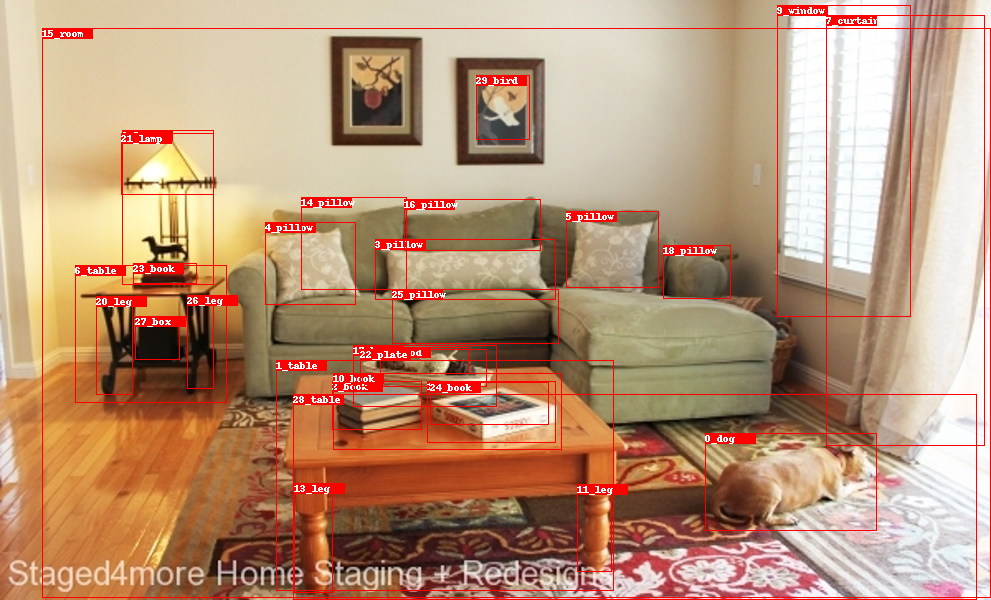

**************************************************
box_labels 0: dog; score: 0.8755963444709778
box_labels 1: table; score: 0.8341425657272339
box_labels 2: book; score: 0.7416272759437561
box_labels 3: pillow; score: 0.7300016283988953
box_labels 4: pillow; score: 0.7011737823486328
box_labels 5: pillow; score: 0.6808720827102661
box_labels 6: table; score: 0.6305738687515259
box_labels 7: curtain; score: 0.6291244029998779
box_labels 8: lamp; score: 0.5750429034233093
box_labels 9: window; score: 0.5192163586616516
box_labels 10: book; score: 0.3213445544242859
box_labels 11: leg; score: 0.305176705121994
box_labels 12: box; score: 0.2888486683368683
box_labels 13: leg; score: 0.2520783841609955
box_labels 14: pillow; score: 0.19981518387794495
box_labels 15: room; score: 0.17370720207691193
box_labels 16: pillow; score: 0.1611514389514923
box_labels 17: book; score: 0.12348420172929764
box_labels 18: pillow; score: 0.085832878947258
box_labels 19: food; score: 0.07868238538503647
bo

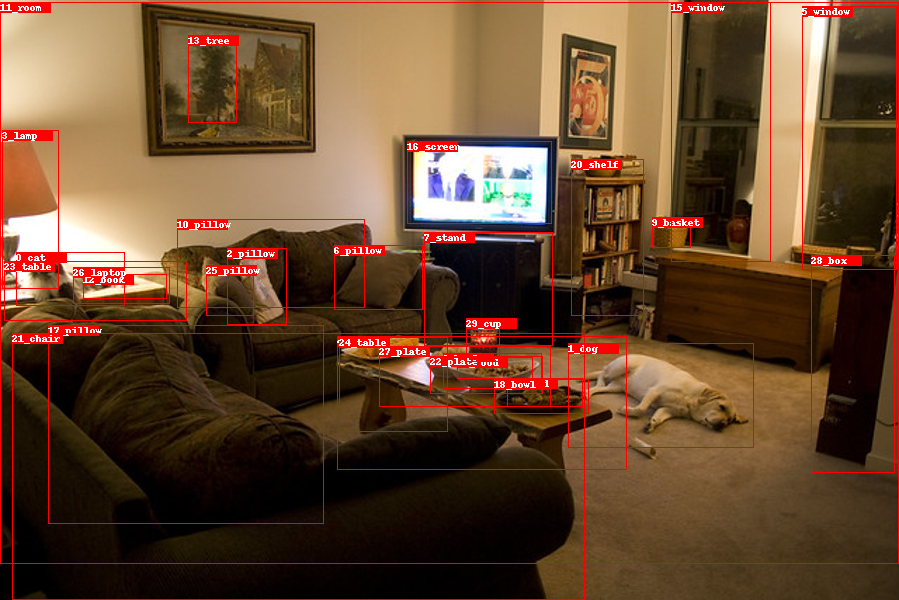

**************************************************
box_labels 0: cat; score: 0.8659942150115967
box_labels 1: dog; score: 0.7350338697433472
box_labels 2: pillow; score: 0.674324095249176
box_labels 3: lamp; score: 0.6309032440185547
box_labels 4: table; score: 0.42733871936798096
box_labels 5: window; score: 0.3572099208831787
box_labels 6: pillow; score: 0.3515182137489319
box_labels 7: stand; score: 0.3200380802154541
box_labels 8: bowl; score: 0.2891721725463867
box_labels 9: basket; score: 0.26060739159584045
box_labels 10: pillow; score: 0.2511173188686371
box_labels 11: room; score: 0.23167867958545685
box_labels 12: book; score: 0.21011215448379517
box_labels 13: tree; score: 0.20001225173473358
box_labels 14: food; score: 0.19170644879341125
box_labels 15: window; score: 0.1800261288881302
box_labels 16: screen; score: 0.16730332374572754
box_labels 17: pillow; score: 0.13789959251880646
box_labels 18: bowl; score: 0.13371017575263977
box_labels 19: food; score: 0.130382314324

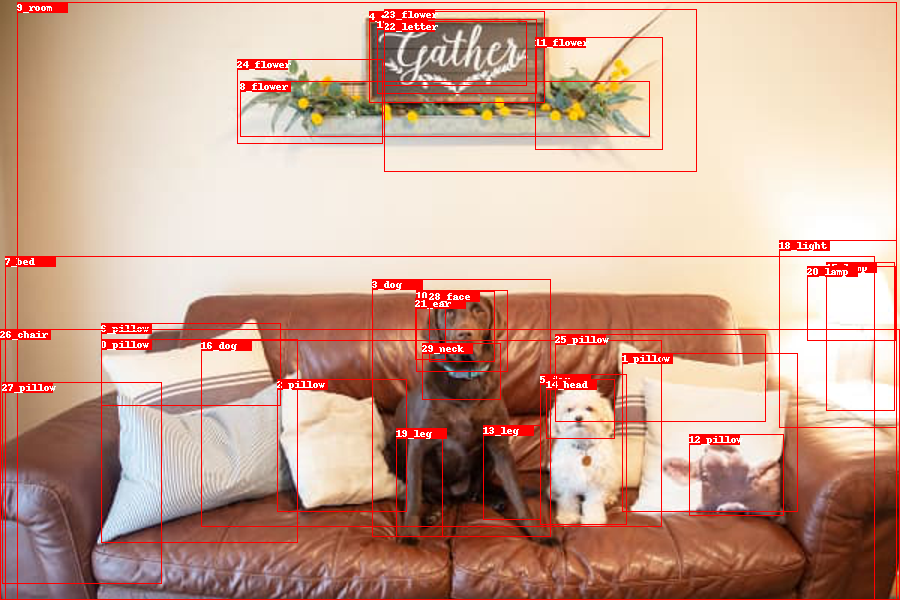

**************************************************
box_labels 0: pillow; score: 0.8784840106964111
box_labels 1: pillow; score: 0.7983406782150269
box_labels 2: pillow; score: 0.7811397314071655
box_labels 3: dog; score: 0.725897490978241
box_labels 4: sign; score: 0.6538888812065125
box_labels 5: dog; score: 0.5823734402656555
box_labels 6: pillow; score: 0.3801751136779785
box_labels 7: bed; score: 0.3265744745731354
box_labels 8: flower; score: 0.2454071193933487
box_labels 9: room; score: 0.24039465188980103
box_labels 10: head; score: 0.23689810931682587
box_labels 11: flower; score: 0.2251482605934143
box_labels 12: pillow; score: 0.11075004190206528
box_labels 13: leg; score: 0.10070444643497467
box_labels 14: head; score: 0.08772672712802887
box_labels 15: lamp; score: 0.08478599786758423
box_labels 16: dog; score: 0.08090768754482269
box_labels 17: logo; score: 0.07913946360349655
box_labels 18: light; score: 0.07058638334274292
box_labels 19: leg; score: 0.06932095438241959
b

In [33]:
viz('alldogsonsofas_abc-23d', 'test', 20, 20)